# Deploying pre-trained PyTorch vision models with Amazon SageMaker Neo On Inf1 Instance

Neo is a capability of Amazon SageMaker that enables machine learning models to train once and run anywhere in the cloud and at the edge. Inf1 instances are built from the ground up to support machine learning inference applications and feature up to 16 AWS Inferentia chips, high-performance machine learning inference chips designed and built by AWS. This notebook will show you how to deploy a pretrained PyTorch model to an Inf1 instance.

Please use sagemaker version at least 2.11.0 in order to support compile PyTorch model on Inf1 instances.

In [1]:
import sys

!{sys.executable} -m pip install -qU "sagemaker>=2.11.0"

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
import sagemaker

print(sagemaker.__version__)

2.69.0


In [3]:
! conda install pytorch torchvision torchaudio cpuonly -c pytorch -y

Solving environment: done

# All requested packages already installed.



## Import ResNet18 from TorchVision

We'll import [ResNet18](https://arxiv.org/abs/1512.03385) model from TorchVision and create a model artifact `model.tar.gz`

In [20]:
import torch
import torchvision.models as models
import tarfile

resnet18 = models.resnet18(pretrained=True)
input_shape = [1, 3, 224, 224]
trace = torch.jit.trace(resnet18.float().eval(), torch.zeros(input_shape).float())
trace.save("model.pth")

with tarfile.open("model.tar.gz", "w:gz") as f:
    f.add("model.pth")
    f.add("resnet18.py")

--------

# Compile Model with Default Settings

We will forward the model artifact to Neo Compilation API. In this section, we will compile model with one core which is the default setting for compilation.

We will go through how to compile model for multiple cores using compiler options in the next section.

In [21]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

compilation_job_name = name_from_base("TorchVision-ResNet18-Neo-Inf1")

model_key = "{}/model/model.tar.gz".format(compilation_job_name)
model_path = "s3://{}/{}".format(bucket, model_key)
boto3.resource("s3").Bucket(bucket).upload_file("model.tar.gz", model_key)
print("Uploaded model to s3:")
print(model_path)

sm_client = boto3.client("sagemaker")
compiled_model_path = "s3://{}/{}/output".format(bucket, compilation_job_name)
print("Output path for compiled model:")
print(compiled_model_path)

Uploaded model to s3:
s3://sagemaker-us-east-1-365792799466/TorchVision-ResNet18-Neo-Inf1-2021-11-18-09-28-32-836/model/model.tar.gz
Output path for compiled model:
s3://sagemaker-us-east-1-365792799466/TorchVision-ResNet18-Neo-Inf1-2021-11-18-09-28-32-836/output


We then create a PyTorchModel object, with default settings.

In [26]:
from sagemaker.pytorch.model import PyTorchModel

pytorch_model = PyTorchModel(
    model_data=model_path,
    role=role,
    entry_point="resnet18.py",
    framework_version="1.6.0",
    py_version="py3",
)

In [27]:
predictor = pytorch_model.deploy(initial_instance_count=1,
                                          instance_type='ml.g4dn.xlarge')

--------!

In [ ]:
predictor.endpoint_name

In [31]:
import json
import numpy as np

# Load names for ImageNet classes
object_categories = {}
with open("imagenet1000_clsidx_to_labels.txt", "r") as f:
    for line in f:
        key, val = line.strip().split(":")
        object_categories[key] = val


#this can be obtained from the sagemaker console under endpoints.
def invoke_endpoint(imagepath):
    endpoint_name = predictor.endpoint_name

    sm_runtime = boto3.Session().client("sagemaker-runtime")

    with open(imagepath, "rb") as image:
        f = image.read()
        b = bytearray(f)
        resp = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType='application/x-image',
                                   Body=b)
        predictions = json.loads(resp['Body'].read().decode('utf-8'))
        preds = np.array(predictions['predictions'][0])
        return object_categories[np.argmax(preds)]
    

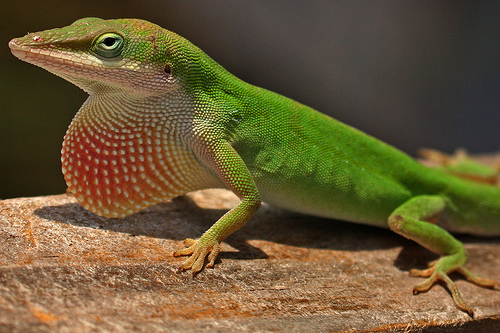

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-79b8911270d4>", line 7, in <module>
    print("Image class: ",invoke_endpoint(file_path))
  File "<ipython-input-31-88d97ec5daca>", line 23, in invoke_endpoint
    Body=b)
  File "/opt/conda/lib/python3.7/site-packages/botocore/client.py", line 386, in _api_call
    return self._make_api_call(operation_name, kwargs)
  File "/opt/conda/lib/python3.7/site-packages/botocore/client.py", line 692, in _make_api_call
    operation_model, request_dict, request_context)
  File "/opt/conda/lib/python3.7/site-packages/botocore/client.py", line 711, in _make_request
    return self._endpoint.make_request(operation_model, request_dict)
  File "/opt/conda/lib/python3.7/site-packages/botocore/endpoint.py", line 102, in make_request
    return self._send_request(request_dict, operation

KeyboardInterrupt: 

In [32]:
file_path = "images/n01682714_American_chameleon.JPEG"

from IPython.display import Image, display

display(Image(file_path))

print("Image class: ",invoke_endpoint(file_path))

## Deploy model on Inf1 instance for real-time inferences

After creating the PyTorch model, we compile the model using Amazon SageMaker Neo to optimize performance for our desired deployment target. To compile our model for deploying on Inf1 instances, we are using the ``compile()`` method and select ``'ml_inf1'`` as our deployment target. The compiled model will then be deployed on an endpoint using Inf1 instances in Amazon SageMaker.

## Compile the model 

The ``input_shape`` is the definition for the model's input tensor and ``output_path`` is where the compiled model will be stored in S3. **Important. If the following command result in a permission error, scroll up and locate the value of execution role returned by `get_execution_role()`. The role must have access to the S3 bucket specified in ``output_path``.**

In [ ]:
neo_model = pytorch_model.compile(
    target_instance_family="ml_inf1",
    input_shape={"input0": [1, 3, 224, 224]},
    output_path=compiled_model_path,
    framework="pytorch",
    framework_version="1.6.0",
    role=role,
    job_name=compilation_job_name,
)

??????????????????????????????

## Deploy the compiled model on a SageMaker endpoint

Now that we have the compiled model, we will deploy it on an Amazon SageMaker endpoint. Inf1 instances in Amazon SageMaker are available in four sizes: ml.inf1.xlarge, ml.inf1.2xlarge, ml.inf1.6xlarge, and ml.inf1.24xlarge. In this example, we are using ``'ml.inf1.xlarge'`` for deploying our model.

In [ ]:
predictor = neo_model.deploy(instance_type="ml.inf1.xlarge", initial_instance_count=1)

-------

In [8]:
predictor.endpoint_name

'sagemaker-neo-pytorch-ml-inf1-2021-11-18-08-42-56-083'

## Invoking the endpoint

Once the endpoint is ready, you can send requests to it and receive inference results in real-time with low latency. 

Let's try to send a cat picture.

![title](cat.jpg)

In [33]:
import json
import numpy as np

sm_runtime = boto3.Session().client("sagemaker-runtime")

with open("cat.jpg", "rb") as f:
    payload = f.read()

response = sm_runtime.invoke_endpoint(
    EndpointName=predictor.endpoint_name, ContentType="application/x-image", Body=payload
)
print(response)
result = json.loads(response["Body"].read().decode())
print("Most likely class: {}".format(np.argmax(result)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-93a3da27aed3>", line 10, in <module>
    EndpointName=predictor.endpoint_name, ContentType="application/x-image", Body=payload
  File "/opt/conda/lib/python3.7/site-packages/botocore/client.py", line 386, in _api_call
    return self._make_api_call(operation_name, kwargs)
  File "/opt/conda/lib/python3.7/site-packages/botocore/client.py", line 692, in _make_api_call
    operation_model, request_dict, request_context)
  File "/opt/conda/lib/python3.7/site-packages/botocore/client.py", line 711, in _make_request
    return self._endpoint.make_request(operation_model, request_dict)
  File "/opt/conda/lib/python3.7/site-packages/botocore/endpoint.py", line 102, in make_request
    return self._send_request(request_dict, operation_model)
  File "/opt/conda/lib/python3.7/site

KeyboardInterrupt: 

In [10]:
# Load names for ImageNet classes
object_categories = {}
with open("imagenet1000_clsidx_to_labels.txt", "r") as f:
    for line in f:
        key, val = line.strip().split(":")
        object_categories[key] = val
print(
    "Result: label - "
    + object_categories[str(np.argmax(result))]
    + " probability - "
    + str(np.amax(result))
)

Result: label -  'tiger cat', probability - 15.10254955291748


## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore, as a clean-up job, we should delete the endpoint.

In [11]:
sess.delete_endpoint(predictor.endpoint_name)

------------------------

# Compile Model for Multiple Cores using Compiler Options
In this section, we will compile the model for two cores and host on sagemaker using 2 sagemaker model server workers to utilize all 4 cores on inf1.xlarge.

In [12]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

compilation_job_name = name_from_base("TorchVision-ResNet18-Neo-Inf1")

model_key = "{}/model/model.tar.gz".format(compilation_job_name)
model_path = "s3://{}/{}".format(bucket, model_key)
boto3.resource("s3").Bucket(bucket).upload_file("model.tar.gz", model_key)
print("Uploaded model to s3:")
print(model_path)

sm_client = boto3.client("sagemaker")
compiled_model_path = "s3://{}/{}/output".format(bucket, compilation_job_name)
print("Output path for compiled model:")
print(compiled_model_path)

Uploaded model to s3:
s3://sagemaker-us-east-1-365792799466/TorchVision-ResNet18-Neo-Inf1-2021-11-18-09-04-11-574/model/model.tar.gz
Output path for compiled model:
s3://sagemaker-us-east-1-365792799466/TorchVision-ResNet18-Neo-Inf1-2021-11-18-09-04-11-574/output


In order to host model compiled for 2 cores, we set environment variables NEURONCORE_GROUP_SIZES and SAGEMAKER_MODEL_SERVER_WORKERS.
### More Information on Environment Variables for Hosting
NEURONCORE_GROUP_SIZES - If the model is compiled for n inferentia cores, set NEURONCORE_GROUP_SIZES=n. For more information on NEURONCORE_GROUP_SIZES, refer to https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/tensorflow-neuron/tutorials/tutorial-tensorflow-NeuronCore-Group.html

SAGEMAKER_MODEL_SERVER_WORKERS - Number of workers required to utilize all inferentia cores. For example, on inf1.2xlarge or inf1.xlarge, if the model is compiled for one core,
we need 4 workers to utilize all inferentia cores which will load the compiled model in different processes. If the model is compiled for 2 cores, we only need 2 workers to utilize 
all inferentia cores.

In [13]:
from sagemaker.pytorch.model import PyTorchModel

pytorch_model = PyTorchModel(
    model_data=model_path,
    role=role,
    entry_point="resnet18.py",
    framework_version="1.5.1",
    py_version="py3",
    env={"NEURONCORE_GROUP_SIZES": "2", "SAGEMAKER_MODEL_SERVER_WORKERS": "2"},
)

## Compile the model 
Then compile the model with compiler options to pass number of cores as 2.

In [14]:
neo_model = pytorch_model.compile(
    target_instance_family="ml_inf1",
    input_shape={"input0": [1, 3, 224, 224]},
    output_path=compiled_model_path,
    framework="pytorch",
    framework_version="1.5.1",
    role=role,
    job_name=compilation_job_name,
    compiler_options='"--verbose 1 --neuroncore-pipeline-cores 2"',
)

????????????????????????????????????.........................................................................!

## Deploy the compiled model on a SageMaker endpoint
Then we need to deploy the compiled model on an Amazon SageMaker endpoint.

In [15]:
predictor = neo_model.deploy(instance_type="ml.inf1.xlarge", initial_instance_count=1)

-----------!

In [16]:
predictor.endpoint_name

'sagemaker-neo-pytorch-ml-inf1-2021-11-18-09-13-37-234'

## Invoking the endpoint

Once the endpoint is ready, you can send requests to it and receive inference results in real-time with low latency. We will use the same cat picture.

In [17]:
import json
import numpy as np

sm_runtime = boto3.Session().client("sagemaker-runtime")

with open("cat.jpg", "rb") as f:
    payload = f.read()

response = sm_runtime.invoke_endpoint(
    EndpointName=predictor.endpoint_name, ContentType="application/x-image", Body=payload
)
print(response)
result = json.loads(response["Body"].read().decode())
print("Most likely class: {}".format(np.argmax(result)))

{'ResponseMetadata': {'RequestId': '551106d5-bd08-40b3-ba66-1536373d5dba', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '551106d5-bd08-40b3-ba66-1536373d5dba', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Thu, 18 Nov 2021 09:19:14 GMT', 'content-type': 'application/json', 'content-length': '20368'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7fb194da5090>}
Most likely class: 282


In [18]:
# Load names for ImageNet classes
object_categories = {}
with open("imagenet1000_clsidx_to_labels.txt", "r") as f:
    for line in f:
        key, val = line.strip().split(":")
        object_categories[key] = val
print(
    "Result: label - "
    + object_categories[str(np.argmax(result))]
    + " probability - "
    + str(np.amax(result))
)

Result: label -  'tiger cat', probability - 15.136762619018555


## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore, as a clean-up job, we should delete the endpoint.

In [ ]:
sess.delete_endpoint(predictor.endpoint_name)

---------